# Titanic Problem
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this exercise, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.


# Data Description
 - survival        Survival(0 = No; 1 = Yes)
 - pclass          Passenger Class(1 = 1st; 2 = 2nd; 3 = 3rd)
 - name            Name
 - sex             Sex
 - age             Age
 - sibsp           Number of Siblings/Spouses Aboard
 - parch           Number of Parents/Children Aboard
 - ticket          Ticket Number
 - fare            Passenger Fare
 - cabin           Cabin
 - embarked        Port of Embarkation(C = Cherbourg; Q = Queenstown; S = Southampton)

# Problem Statement
Based on problem description, I decided to treat this as a classification problem by trying to predict the value of <b>Survived</b> variable for each instance.

In order to finish this task and create a model to predict who survived or died? I will use following libraries:
- NumPy
- IPython
- Pandas
- SciKit-Learn
- SciPy
- StatsModels
- Patsy
- Matplotlib


## Import Modules

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.cross_validation import cross_val_score, train_test_split

from patsy import dmatrices
import sys

# sys.path.append('/usr/local/lib/python2.7/dist-packages')
# sys.path.append('/usr/local/lib/python2.7/site-packages')

import seaborn as sbn

## 1. Get understanding about the data

### 1.1. Data Preprocessing
Load the data into Pandas Data Frame

In [4]:
train = pd.read_csv("data/train.csv")
train[train.columns[1:]].head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


Start with basic statistical descriptions and univariate audit of the different columns. 

In [8]:
# Try some basic statistical descriptions for Numeric values ()
train[['Survived', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch']].describe(include='all')

,Survived,Pclass,Age,Fare,SibSp,Parch
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,32.204208,0.523008,0.381594
std,0.486592,0.836071,14.526497,49.693429,1.102743,0.806057
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,7.910400,0.000000,0.000000
50%,0.000000,3.000000,28.000000,14.454200,0.000000,0.000000
75%,1.000000,3.000000,38.000000,31.000000,1.000000,0.000000
max,1.000000,3.000000,80.000000,512.329200,8.000000,6.000000


Firstly, we  can easy to see that we have  891 observations, or passengers in the data set. Based on the above output, we have some missing data for Age column.

In order to handle the missing data, we assume that we can fill all of missing data by average of age.

In [39]:
# Cleaning the age column
train.Age = train.Age.fillna(train.Age.mean())

In [10]:
# Consider some possible text values
train[['Sex', 'Ticket', 'Cabin', 'Embarked']].describe(include='all')

,Sex,Ticket,Cabin,Embarked
count,891,891,204,889
unique,2,681,147,3
top,male,CA. 2343,C23 C25 C27,S
freq,577,7,4,644


From output, we see Ticket is very diversified (unique = 681 vs count = 891), Cabin is diversified and contains a lot of missing data as well. Hence they can be meaningless features, we can drop them.

There is a little missing data for Embarked column, we can fill all of them by top value (S).

In [40]:
# Drop meaningless columns
# df = df.drop(['Ticket','Cabin'], axis=1)

# Cleaning the Embarked columns
train.Embarked = train.Embarked.fillna('S')

### 1.2. Data Exploration and Visualization
There are two types of variable in our dataset:
  - Categorical Variables: Pclass, Sex and Embarked
  - Numeric Variables: Age, SibSp, Parch, Fare

In [12]:
train.groupby('Survived')['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'].mean()

,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,2.531876,30.415100,0.553734,0.329690,22.117887
1,1.950292,28.549778,0.473684,0.464912,48.395408


Base on the output, we can easy to make some hypotheses: Who can survive?
 - Passengers in high class (1st Class or 2nd Class)
 - Adult with average age: 28
 - Rich passengers based on Fare price.

Now we take a look closer into the data graphically and see what is the shape of data?

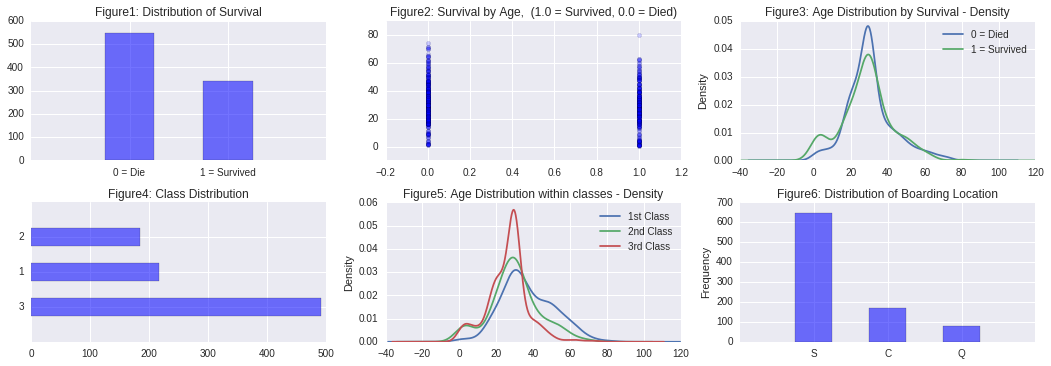

In [14]:
# Pre-define some parameters of charts
plt.figure(figsize=(18,9), dpi=1600)
plt.subplots_adjust(hspace = 0.3)
alpha = 0.2 
alpha_bar_chart = 0.55

# Create a grid of charts 
# Display distribution of Survival
ax1 = plt.subplot2grid((3,3),(0,0))
train.Survived.value_counts().plot(kind = 'bar', alpha = alpha_bar_chart)
ax1.set_xlim(-1, 2)
ax1.set_xticklabels(["0 = Die", "1 = Survived"], rotation=0)
plt.title("Figure1: Distribution of Survival")

ax2 = plt.subplot2grid((3,3),(0,1))
plt.scatter(train.Survived, train.Age, alpha = alpha)
plt.grid(b=True, which='major', axis='y')  
plt.title("Figure2: Survival by Age,  (1.0 = Survived, 0.0 = Died)")

plt.subplot2grid((3,3),(0,2))
train.Age[train.Survived == 0].plot(kind='kde') 
train.Age[train.Survived == 1].plot(kind='kde')
plt.grid(b=True, which='major', axis='y') 
plt.title("Figure3: Age Distribution by Survival - Density")
plt.legend(('0 = Died', '1 = Survived'),loc='best')

ax3 = plt.subplot2grid((3,3),(1,0))
train.Pclass.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, 3)
plt.grid(b=True, which='major', axis='y')
plt.title("Figure4: Class Distribution")

plt.subplot2grid((3,3),(1,1))
train.Age[train.Pclass == 1].plot(kind='kde')    
train.Age[train.Pclass == 2].plot(kind='kde')
train.Age[train.Pclass == 3].plot(kind='kde')
plt.grid(b=True, which='major', axis='y') 
plt.title("Figure5: Age Distribution within classes - Density")
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best')

ax5 = plt.subplot2grid((3,3),(1,2))
train.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart, rot=0)
ax5.set_xlim(-1, 3)
plt.title("Figure6: Distribution of Boarding Location")
plt.ylabel('Frequency')

The above charts show us clear illustration for the hypotheses. We can see there are some relationships (or associations) between Survived and other variables (Age, Pclass, Embarked...)

The features for prediction model should contain:
 - Sex 
 - Pclass (travelling class)
 - Age
 - SibSp, Parch, Fare
 - Embarked

Next section, we will go insights on the profiles of the people that survive and find about which variables to be the most correlated with this phenomenon.

## 2. Feature Selection

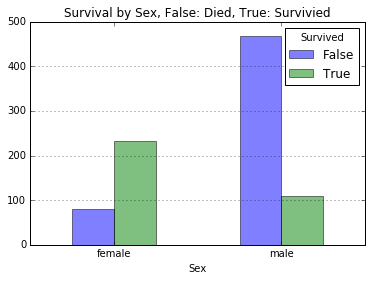

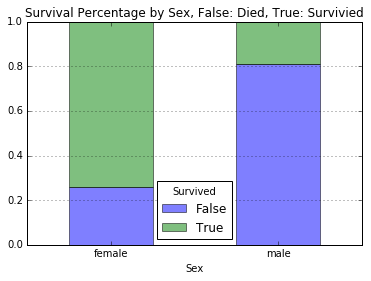

In [36]:
# Take a closer look into relationship between Survived and Sex
survived_sex = pd.crosstab(train.Sex, train.Survived.astype(bool))
survived_sex.plot(kind='bar', alpha=0.5, rot=0, layout=(2,1))
plt.grid(b=True, which='major', axis='y') 
plt.title("Survival by Sex, False: Died, True: Survivied")

survived_sex.div(survived_sex.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, alpha=0.5, rot=0)
plt.grid(b=True, which='major', axis='y')
plt.title("Survival Percentage by Sex, False: Died, True: Survivied")

The above charts show us clearly that male will be died much more than femal, females had a greater survival rate (~75%), than men (~20%).

Definitely, <b>Sex</b> is one of significant feature for the prediction model. So we will take it into account. Next we consider the relationship between Survived and Pclass


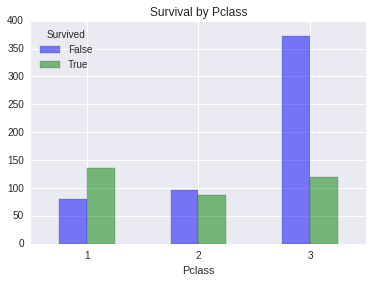

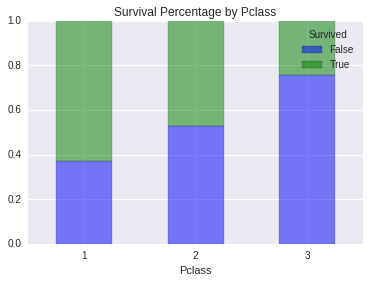

In [16]:
survived_pclass = pd.crosstab(train.Pclass, train.Survived.astype(bool))
survived_pclass.plot(kind='bar', alpha=0.5, rot=0)
plt.grid(b=True, which='major', axis='y')
plt.title("Survival by Pclass")

survived_pclass.div(survived_pclass.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, alpha=0.5, rot=0)
plt.title("Survival Percentage by Pclass")
plt.grid(b=True, which='major', axis='y')

The charts illustrate that business class passengers(Pclass = 1 or 2) have survival rate much higher than economy class (Pclass = 3) passengers. Therefore, <b>Pclass</b> variable seem to be one of the most correlated variables.

Next we will take a different look into how multiple variables (Sex, Fare, Age, Pclass) affect to <b>Survived</b>.

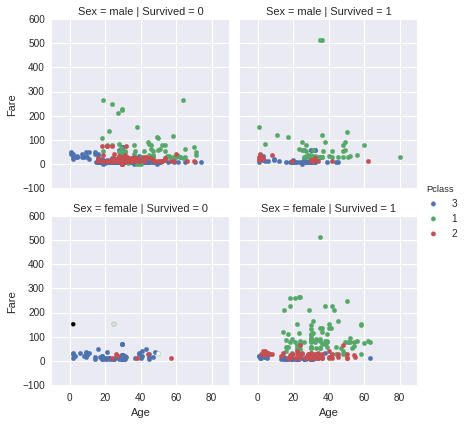

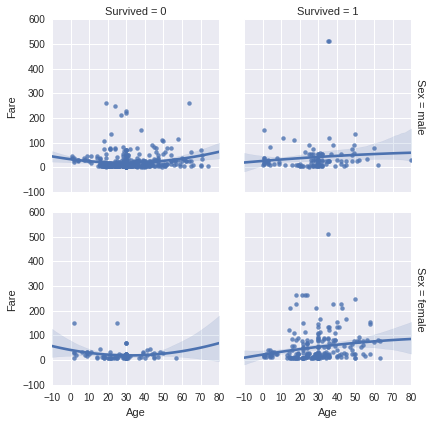

In [19]:
g = sbn.FacetGrid(train, row="Sex", col="Survived", hue="Pclass")
g.map(plt.scatter, "Age", "Fare")
g.add_legend()

g = sbn.FacetGrid(train, row="Sex", col="Survived", margin_titles=True)
g.map(sbn.regplot, "Age", "Fare", order=2)

Next section, we will try doing some experiments with the selected features and training data. We will try three different models:
 - Binary Logit Regression
 - Decision Tree
 - Random Forest

 ### 3. Train model

In [41]:
# Generate feature vectors for our models
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Embarked)'
Y,X = dmatrices(formula, data=train, return_type='dataframe')
Y = np.ravel(Y)
# Y target
# X features
score_res = {}

#### 3.1. Logit Regression

In [22]:
# create an empty model
logit = LogisticRegression()
# train model
logit_model = logit.fit(X, Y)

# check the accuracy on the training set
accuracy = logit_model.score(X, Y)
print "Mean accuracy of Logit Regression on the data was: %s" % accuracy

Mean accuracy of Logit Regression on the data was: 0.804713804714


In [24]:
# Look inside the training model
pd.DataFrame(zip(X.columns, np.transpose(logit_model.coef_)))

,0,1
0,Intercept,[1.85781536579]
1,C(Pclass)[T.2],[-0.818994356201]
2,C(Pclass)[T.3],[-2.01622956576]
3,C(Sex)[T.male],[-2.53210626849]
4,C(Embarked)[T.Q],[-0.0214593157773]
5,C(Embarked)[T.S],[-0.428004370368]
6,Age,[-0.0327930224222]
7,SibSp,[-0.275664334308]
8,Parch,[-0.0444663003299]


10-folds cross validattion

In [26]:
scores = cross_val_score(LogisticRegression(), X, Y, scoring='f1', cv=10)
score_res['Logit'] = scores
print scores

[ 0.71641791  0.73529412  0.66666667  0.7826087   0.75        0.6984127
  0.68852459  0.6557377   0.76190476  0.76923077]


### 3.2. Decision Tree

In [28]:
# Create empty tree
dtree = DecisionTreeClassifier()
dtree_model = dtree.fit(X, Y)

# check the accuracy on the training set
accuracy = dtree_model.score(X, Y)
print "Mean accuracy of Decision Tree on the data was: %s" % accuracy

Mean accuracy of Decision Tree on the data was: 0.937149270483


10-folds cross validattion

In [29]:
scores = cross_val_score(DecisionTreeClassifier(), X, Y, scoring='f1', cv=10)
score_res['DTree'] = scores
print scores

[ 0.61111111  0.64705882  0.63333333  0.79411765  0.77142857  0.72727273
  0.74193548  0.66666667  0.74285714  0.72463768]


Save the tree to dot file

In [33]:
dotfile = open("output/dtree.dot", 'w')
export_graphviz(dtree_model, out_file = dotfile, feature_names = X.columns)
dotfile.close()

### 3.3. Random Forest


In [34]:
# RandomForestClassifier expects a 1 demensional NumPy array, so we convert
#instantiate and fit our model
forest_model = RandomForestClassifier(n_estimators=100).fit(X, Y)

# Score the results
score = forest_model.score(X, Y)
print "Mean accuracy of Random Forest Predictions on the data was: {0}".format(score)

Mean accuracy of Random Forest Predictions on the data was: 0.937149270483


In [35]:
scores = cross_val_score(RandomForestClassifier(n_estimators=100), X, Y, scoring='f1', cv=10)
score_res['RandForest'] = scores
print scores

[ 0.63013699  0.70769231  0.63333333  0.8         0.8         0.74626866
  0.78688525  0.6557377   0.74626866  0.82857143]


### 3.4. Model Comparision

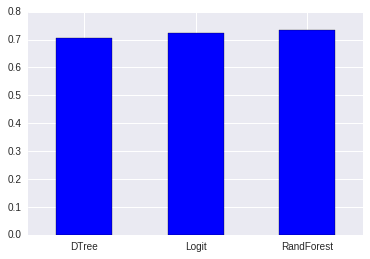

In [36]:
result = pd.DataFrame.from_dict(score_res)
result.mean().plot(kind = 'bar', rot = 0)

<b>Random Forest</b> seem to be a best model for our data.

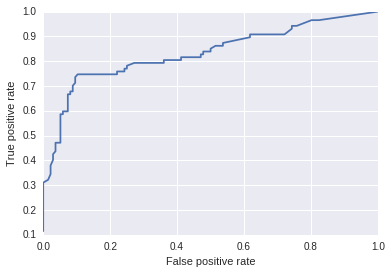

In [37]:
# viz the predict curve
features_train, features_test, target_train, target_test = train_test_split(X, Y)

rand_forest = RandomForestClassifier(n_estimators=100)
rand_forest.fit(features_train, target_train)
predictions = rand_forest.predict(features_test)
# print confusion_matrix(predictions, target_test)

scores = rand_forest.predict_proba(features_test).transpose()[1]

fpr, tpr, thresholds = roc_curve(target_test, scores)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(fpr, tpr)

#### Lets look at the predictions we generated graphically

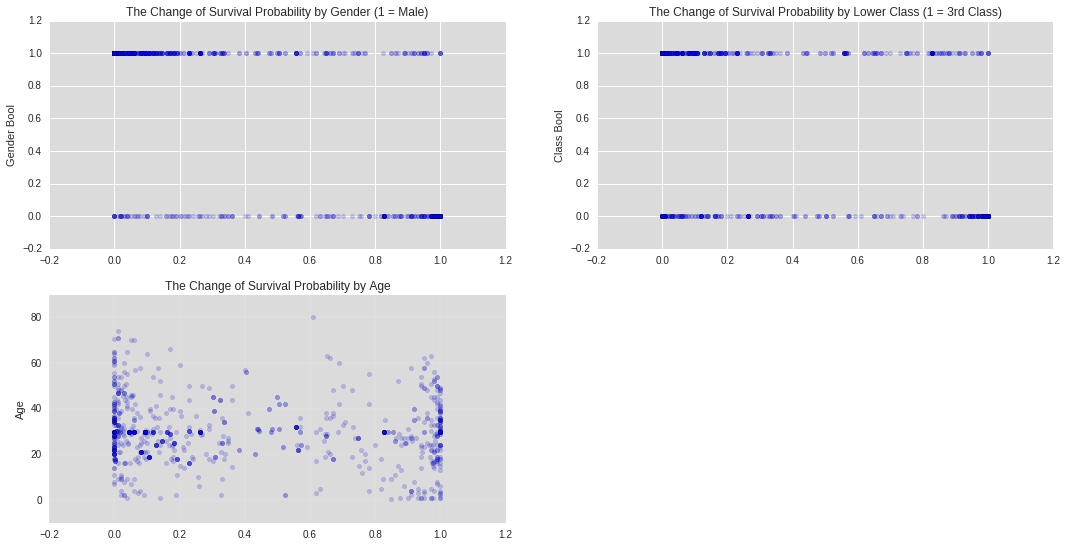

In [38]:
# # model.predict(x)
probs = forest_model.predict_proba(X).transpose()[1]

fig = plt.figure(figsize=(18,9), dpi=1000)
a = 0.2

fig.add_subplot(221, axisbg="#DBDBDB")
plt.scatter(probs, X['C(Sex)[T.male]'] , alpha=a)
plt.grid(b=True, which='major', axis='x')
plt.ylabel("Gender Bool")
plt.title("The Change of Survival Probability by Gender (1 = Male)")

fig.add_subplot(222, axisbg="#DBDBDB")
plt.scatter(probs,X['C(Pclass)[T.3]'] , alpha=a)
plt.ylabel("Class Bool")
plt.grid(b=True, which='major', axis='x')
plt.title("The Change of Survival Probability by Lower Class (1 = 3rd Class)")

fig.add_subplot(223, axisbg="#DBDBDB")
plt.scatter(probs, X.Age, alpha=a)
plt.grid(True, linewidth=0.15)
plt.title("The Change of Survival Probability by Age")
plt.ylabel("Age")

#### Now lets use our model to predict the test set 

## 5. Model Tunning

#### Model Analysis
For production, we need to have a good performance and stable model. Thats why we need to tune the model to get the best one.

There are two approaches to refine the model:
 - Feature engineering
 - Parameters tunning
 
In this notebook, I just focused on the second one. Now we take a look a little bit about our prediction results.

In [69]:
# Let see the confusion matrix
matrix = pd.DataFrame(confusion_matrix(forest_model.predict(X), Y))
error = [float(matrix[0][1])/matrix[0][0], float(matrix[1][0])/matrix[1][1]]
matrix['class.error'] = np.array(error)
matrix

,0,1,class.error
0,529,36,0.037807
1,20,306,0.117647


This shows some bias in the predictions. Class one gets predicted as class 0 far too often. Hence I need to do some optimizations of model parameters.

There are two type of parameters, more details <a href='http://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/'>here:</a>
 - Parameters which make predictions of the model better
     + max_features: increasing max_features generally improves the performance of the model, but for sure, it could decrease the speed of training. 
     + n_estimators: number of decision trees, increasing n_estimators improves the performance but descrease the speed of training
     + min_sample_leaf: minimum size of leaf node
 - Parameter which will make the model training easier
     + n_jobs: how many processors is it allowed to use? if n_jobs = -1, it will use all of possible processors
     + random_state: use 50 as a recommendation
     + oob_score: True

In [77]:
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

pipeline = Pipeline([('clf', RandomForestClassifier(random_state=50))])
parameters = {
'clf__n_estimators': (50, 100, 200),
'clf__max_depth': (50, 150, 250),
'clf__min_samples_split': (1, 2, 3, 4, 5),
'clf__min_samples_leaf': (1, 2, 3, 4, 5)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1,verbose=1, scoring='f1')
grid_search.fit(X, Y)
print 'Best score: %0.3f' % grid_search.best_score_
print 'Best parameters set:'

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])

predictions = grid_search.predict(X)
print classification_report(Y, predictions)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:   10.5s finished


Best score: 0.741
Best parameters set:
	clf__max_depth: 50
	clf__min_samples_leaf: 5
	clf__min_samples_split: 1
	clf__n_estimators: 200
             precision    recall  f1-score   support

        0.0       0.83      0.94      0.88       549
        1.0       0.88      0.69      0.77       342

avg / total       0.85      0.85      0.84       891



In [78]:
best_model = RandomForestClassifier(n_estimators = 200, n_jobs = -1,
                                  random_state =50, max_features = "auto", 
                                  min_samples_leaf = 5, min_samples_split=1, max_depth=50)
best_model.fit(X,Y)
print 'Stable score: %s' % best_model.score(X, Y)

Stable score: 0.845117845118


## 4. Apply the model

Load test set and do the same thing as training set

In [72]:
test = pd.read_csv("data/test.csv")
test.Age = test.Age.fillna(train.Age.mean())
test.Fare = test.Fare.fillna(train.Fare.median())
test.Embarked = test.Embarked.fillna('S')

There is no <b>Survived</b> column in test set, so we will add one with default value: 0

In [73]:
test['Survived'] = 0

Create test vector and target vector for validation

In [74]:
Y_test, X_test = dmatrices(formula, data=test, return_type='dataframe')

# get prediction
predict_res = best_model.predict(X_test)

### Validate the result
This is one of the most challenging in the task. Because we don't have the true label for each instance in test data. And here is my approach:
- Try one solution in R from <a href='http://www.r-bloggers.com/predicting-titanic-deaths-on-kaggle/'>here</a> to generate a Kaggle's output
- Also use my model to generate the same output
- Submit both of outputs into <a href='https://www.kaggle.com/c/titanic'>Kaggle</a> and compare the scores.

Generate Kaggle's output from my model

In [75]:
processed_df = test[['PassengerId', 'Survived']]
processed_df.Survived = predict_res.astype(int)
processed_df.to_csv('output/mymodel.csv', index=False)

- Result for R solution: 0.74163
- Result for my solution: <b>0.78947</b>

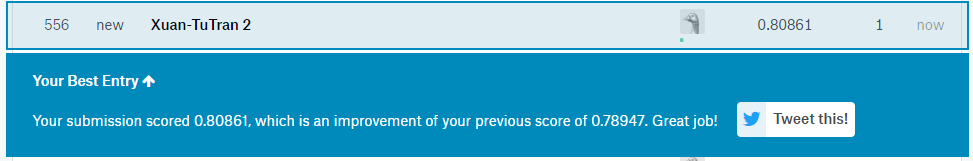

In [1]:
from IPython.display import Image
Image(filename='./titanic.PNG') 

# How to score 0.80861 in Titanic Kaggle Challenge
reference from <a href='http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html'>here</a>

In [408]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# combine (train and test) data
def get_combined_data():
    # reading train data
    train = pd.read_csv('data/train.csv')
    
    # reading test data
    test = pd.read_csv('data/test.csv')

    # extracting and then removing the targets from the training data 
    targets = train.Survived
    #train.drop('Survived',1,inplace=True)

    # merging train data and test data for future feature engineering
    combined = train.append(test)
    combined.drop('Survived',1,inplace=True)
    combined.reset_index(inplace=True)
    combined.drop('index',inplace=True,axis=1)
    
    return combined, targets

In [409]:
combined, targets = get_combined_data()

In [410]:
combined.shape

(1309, 11)

### Extracting the passenger tittles
 
 - Braund, <b>Mr.</b> Owen Harris
 - Heikkinen, <b>Miss.</b> Laina
 - Oliva y Ocana, <b>Dona.</b> Fermina
 - Peter, <b>Master.</b> Michael J

In [411]:
combined.Name.str.extract(',\s(.+?)\.').value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Mme               1
the Countess      1
Don               1
Lady              1
Sir               1
Jonkheer          1
Dona              1
Capt              1
Name: Name, dtype: int64

 - Base on above results, we will nomalize and group the titles by some simple rules
     + (Capt - Captain, Col - Colonel, Major, Dr - Doctor, Rev - Reverend) named as <b>Officer</b>
     + (Jonkheer, Don or Dona - Lord, Sir, Lady, the Countess) named as <b>Royalty</b>
     + (Mme, Ms) named as <b>Mrs</b>
     + Mlle named as <b>Miss</b>

In [412]:
def get_titles():
    global combined
    
    # we extract the title from each name
    combined['Title'] = combined.Name.str.extract(',\s(.+?)\.')
    
    # a map of more aggregated titles
    title_mapping = {
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "the Countess":"Royalty",
        "Dona":       "Royalty",
        "Mme":        "Mrs",
        "Mlle":       "Miss",
        "Ms":         "Mrs",
        "Mr" :        "Mr",
        "Mrs" :       "Mrs",
        "Miss" :      "Miss",
        "Master" :    "Master",
        "Lady" :      "Royalty"
    }
    
    # we map each title
    combined['Title'] = combined.Title.map(title_mapping)
    combined.drop('Name',1,inplace=True)
    combined.reset_index(inplace=True)
    combined.drop('index',inplace=True,axis=1)

In [413]:
get_titles()

In [431]:
combined[combined.Cabin.isnull()][combined.Pclass==1]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
30,31,1,male,40,0,0,PC 17601,27.7208,NaN,C,Royalty
34,35,1,male,28,1,0,PC 17604,82.1708,NaN,C,Mr
35,36,1,male,42,1,0,113789,52.0000,NaN,S,Mr
64,65,1,male,NaN,0,0,PC 17605,27.7208,NaN,C,Mr
83,84,1,male,28,0,0,113059,47.1000,NaN,S,Mr
155,156,1,male,51,0,1,PC 17597,61.3792,NaN,C,Mr
168,169,1,male,NaN,0,0,PC 17318,25.9250,NaN,S,Mr
187,188,1,male,45,0,0,111428,26.5500,NaN,S,Mr
256,257,1,female,NaN,0,0,PC 17585,79.2000,NaN,C,Mrs
258,259,1,female,35,0,0,PC 17755,512.3292,NaN,C,Miss


In [426]:
combined[combined.Cabin.isnull()].groupby(["Embarked", "Pclass"]).count()

PassengerId  Sex  Age  SibSp  Parch  Ticket  Fare  Cabin  \
Embarked Pclass                                                             
C        1                30   30   20     30     30      30    30      0   
         2                24   24   21     24     24      24    24      0   
         3                98   98   59     98     98      98    98      0   
Q        2                 6    6    5      6      6       6     6      0   
         3               112  112   42    112    112     112   112      0   
S        1                37   37   26     37     37      37    37      0   
         2               224  224  214    224    224     224   224      0   
         3               483  483  387    483    483     483   482      0   

                 Title  
Embarked Pclass         
C        1          30  
         2          24  
         3          98  
Q        2           6  
         3         112  
S        1          37  
         2         224  
         3         483

In [427]:
combined[~combined.Cabin.isnull()].groupby(["Embarked", "Pclass"]).count()

PassengerId  Sex  Age  SibSp  Parch  Ticket  Fare  Cabin  \
Embarked Pclass                                                             
C        1               111  111  108    111    111     111   111    111   
         2                 4    4    3      4      4       4     4      4   
         3                 3    3    1      3      3       3     3      3   
Q        1                 3    3    3      3      3       3     3      3   
         2                 1    1    0      1      1       1     1      1   
         3                 1    1    0      1      1       1     1      1   
S        1               140  140  125    140    140     140   140    140   
         2                18   18   18     18     18      18    18     18   
         3                12   12   12     12     12      12    12     12   

                 Title  
Embarked Pclass         
C        1         111  
         2           4  
         3           3  
Q        1           3  
         2           1  
         3           1  
S        1         140  
         2          18  
         3          12

### Handle missing value

In [415]:
# see what are missing values
combined.isnull().sum()

PassengerId       0
Pclass            0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Title             0
dtype: int64

###### We can see here: Age, Fare, Cabin and Embarked are columns that contain some missing values
- Age: we will use regression method to predict missing value
- Fare: will be replaced by Median
- Embarked: will be replaced by Mode (most frequent value)
- Cabin: others

#### Processing the Ages

In [362]:
combined[combined.Fare.isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1043,1044,3,male,60.5,0,0,3701,NaN,NaN,S,Mr


In [363]:
combined["Age"].mean()

29.881137667304014

In [364]:
grouped = combined.groupby(['Sex','Pclass','Title'])
grouped.median()

PassengerId   Age  SibSp  Parch      Fare
Sex    Pclass Title                                             
female 1      Miss           529.5  30.0      0      0   99.9625
              Mrs            853.5  45.0      1      0   78.1125
              Officer        797.0  49.0      0      0   25.9292
              Royalty        760.0  39.0      0      0   86.5000
       2      Miss           606.5  20.0      0      0   20.2500
              Mrs            533.0  30.0      1      0   26.0000
       3      Miss           603.5  18.0      0      0    8.0500
              Mrs            668.5  31.0      1      1   15.5000
male   1      Master         803.0   6.0      1      2  134.5000
              Mr             634.0  41.5      0      0   47.1000
              Officer        678.0  52.0      0      0   37.5500
              Royalty        600.0  40.0      0      0   27.7208
       2      Master         550.0   2.0      1      1   26.0000
              Mr             723.5  30.0      0      0   13.0000
              Officer        513.0  41.5      0      0   13.0000
       3      Master         789.0   6.0      3      1   22.3583
              Mr             640.5  26.0      0      0    7.8958

In [365]:
def process_age():
    
    global combined
    
    # a function that fills the missing values of the Age variable
    
    def fillAges(row):
        if row['Sex']=='female' and row['Pclass'] == 1:
            if row['Title'] == 'Miss':
                return 30
            elif row['Title'] == 'Mrs':
                return 45
            elif row['Title'] == 'Officer':
                return 49
            elif row['Title'] == 'Royalty':
                return 39

        elif row['Sex']=='female' and row['Pclass'] == 2:
            if row['Title'] == 'Miss':
                return 20
            elif row['Title'] == 'Mrs':
                return 30

        elif row['Sex']=='female' and row['Pclass'] == 3:
            if row['Title'] == 'Miss':
                return 18
            elif row['Title'] == 'Mrs':
                return 31

        elif row['Sex']=='male' and row['Pclass'] == 1:
            if row['Title'] == 'Master':
                return 6
            elif row['Title'] == 'Mr':
                return 41.5
            elif row['Title'] == 'Officer':
                return 52
            elif row['Title'] == 'Royalty':
                return 40

        elif row['Sex']=='male' and row['Pclass'] == 2:
            if row['Title'] == 'Master':
                return 2
            elif row['Title'] == 'Mr':
                return 30
            elif row['Title'] == 'Officer':
                return 41.5

        elif row['Sex']=='male' and row['Pclass'] == 3:
            if row['Title'] == 'Master':
                return 6
            elif row['Title'] == 'Mr':
                return 26
    
    combined.Age = combined.apply(lambda r : fillAges(r) if np.isnan(r['Age']) else r['Age'], axis=1)

In [366]:
process_age()

#### Processing the Fares

In [367]:
def proces_fares():
    
    global combined
    combined.Fare.fillna(combined.Fare.median(),inplace=True)

In [368]:
proces_fares()

#### Processing the Embarked

In [370]:
def process_embarked():
    
    global combined
    # two missing embarked values - filling them with the most frequent one (S)
    combined.Embarked.fillna('S',inplace=True)
    
    # dummy encoding 
    embarked_dummies = pd.get_dummies(combined['Embarked'],prefix='Embarked')
    combined = pd.concat([combined,embarked_dummies],axis=1)
    combined.drop('Embarked',axis=1,inplace=True)

In [371]:
process_embarked()

#### Processing the Pclass

In [372]:
def process_pclass():
    global combined
    
    pclass_dummies = pd.get_dummies(combined.Pclass, prefix='Pclass')
    combined = pd.concat([combined, pclass_dummies], axis=1)
    combined.drop('Pclass', axis=1, inplace=True)

In [373]:
process_pclass()

#### Processing the Sex

In [374]:
def process_sex():
    global combined
    
    gender_map = {
        'male': 1,
        'female': 0
    }
    combined['Sex'] = combined['Sex'].map(gender_map)

In [375]:
process_sex()

#### Exploring the Family size

In [376]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s : 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s : 1 if 2<=s<=4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s : 1 if 5<=s else 0)

In [377]:
process_family()

#### Exploring the title of passenger name

In [378]:
def process_title():
    
    global combined
    feature = 'Title'
    
    # dummy title
    title_dummies = pd.get_dummies(combined[feature], prefix=feature)
    combined = pd.concat([combined, title_dummies], axis=1)
    combined.drop(feature, axis=1,inplace=True)

In [379]:
process_title()

#### Exploring the Cabin

In [380]:
def process_cabin():
    
    global combined
    feature = 'Cabin'
    
    # replacing missing cabins with U (for Uknown)
    combined.Cabin.fillna('U',inplace=True)
    
    # mapping each Cabin value with the cabin letter
    combined[feature] = combined[feature].map(lambda c : c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(combined['Cabin'],prefix='Cabin')
    
    combined = pd.concat([combined,cabin_dummies],axis=1)
    
    combined.drop(feature,axis=1,inplace=True)

In [381]:
process_cabin()

#### Exploring the Ticket

In [382]:
def process_ticket():
    
    global combined
    feature = 'Ticket'
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def clean_ticket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip() , ticket)
        ticket = filter(lambda t : not t.isdigit(), ticket)
        if len(ticket) > 0:
            return ticket[0].lower()
        else: 
            return 'Others'
    

    # Extracting dummy variables from tickets:
    combined[feature] = combined[feature].map(clean_ticket)
    tickets_dummies = pd.get_dummies(combined[feature],prefix=feature)
    combined = pd.concat([combined, tickets_dummies],axis=1)
    combined.drop(feature,inplace=True,axis=1)
    

In [383]:
process_ticket()

In [384]:
combined.shape

(1309, 67)

###### Finally, we have 67 features
 - Because, the features range in different intervals. Let's normalize all of them in the unit interval. All of them except the PassengerId that we'll need for the submission.


In [385]:
def scale_all_features():
    
    global combined
    
    features = list(combined.columns)
    features.remove('PassengerId')
    combined[features] = combined[features].apply(lambda x: x/x.max(), axis=0)
    #print 'Features scaled successfully !'

In [386]:
scale_all_features()

In [387]:
combined.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Ticket_sopp,Ticket_sotono2,Ticket_sotonoq,Ticket_sp,Ticket_stono,Ticket_stono2,Ticket_stonoq,Ticket_swpp,Ticket_wc,Ticket_wep
0,1,1,0.2750,0.125,0,0.014151,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0.4750,0.125,0,0.139136,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0.3250,0.000,0,0.015469,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,0,0.4375,0.125,0,0.103644,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0.4375,0.000,0,0.015713,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Modeling

#### Feature Selection

In [388]:
def recover_train_test():
    global combined
    
    train = combined.ix[0:890]
    test = combined.ix[891:]
    
    return train,test

In [389]:
train, test = recover_train_test()

In [390]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=200, random_state=42)
clf = clf.fit(train, targets)

features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_

In [406]:
cols = [u'PassengerId', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
       u'Pclass_1', u'Pclass_3', u'FamilySize', u'SmallFamily', u'LargeFamily',
       u'Title_Miss', u'Title_Mr', u'Title_Mrs', u'Cabin_S']

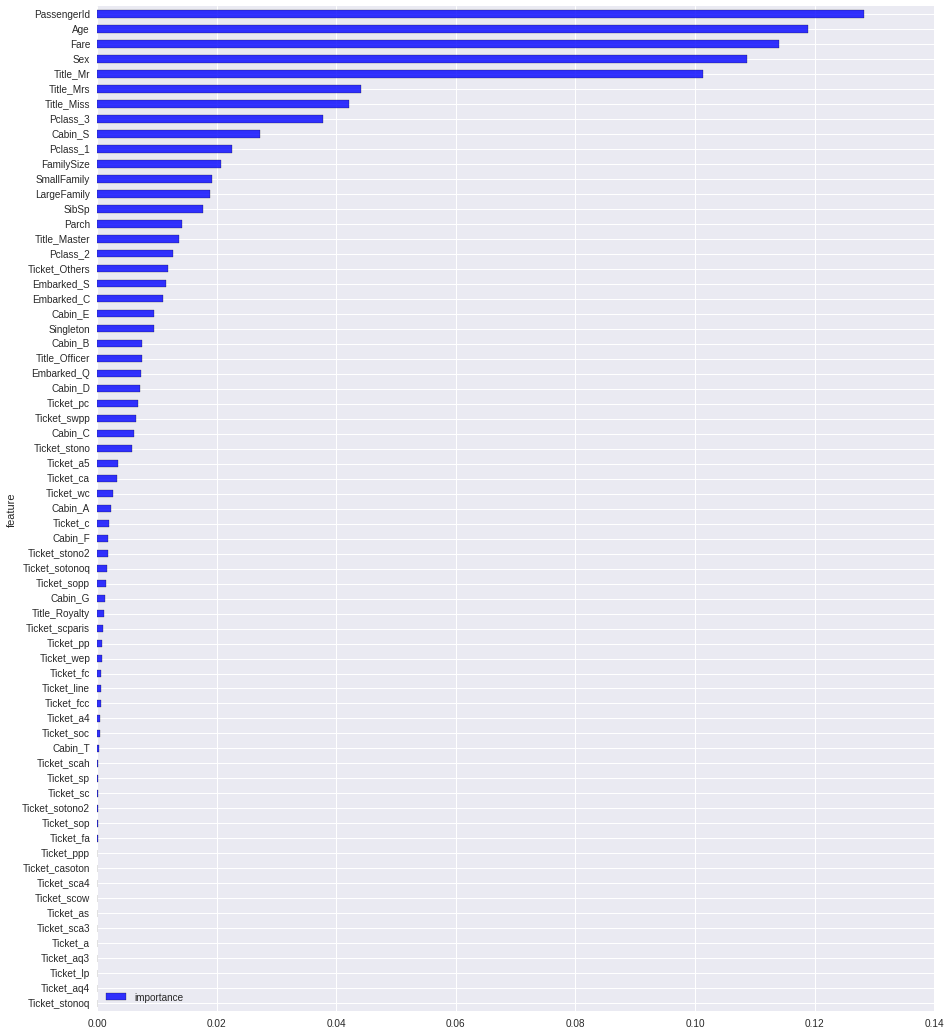

In [395]:
features.set_index(['feature']).sort(['importance'],ascending=True).plot(kind='barh', alpha = 0.8, figsize=(15,18))

In [396]:
# select important features
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(train)
train_new.shape

(891, 14)

In [397]:
test_new = model.transform(test)
test_new.shape

(418, 14)

#### Hyperparameters tuning

In [407]:
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features=7, max_leaf_nodes=None, min_samples_leaf=12,
            min_samples_split=27, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=True, random_state=42)

parameter_grid = {
                 #'max_features' : [6,7,8],
                 #'min_samples_split': [27, 45],
                 #'max_depth': [4,6]
                 }

cross_validation = StratifiedKFold(targets, n_folds=5)

grid_search = GridSearchCV(forest,
                           param_grid=parameter_grid,
                           cv=cross_validation, scoring='roc_auc')

grid_search.fit(train[cols], targets)


print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.866733338769
Best parameters: {}


In [432]:
output = grid_search.predict(test[cols]).astype(int)
df_output = pd.DataFrame()
df_output['PassengerId'] = test['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('data/output.csv',index=False)

### Validation

In [433]:
result = pd.read_csv("data/output.csv")

In [435]:
apply_data = pd.read_csv("data/test.csv")

In [436]:
apply_data.Survived = result.Survived

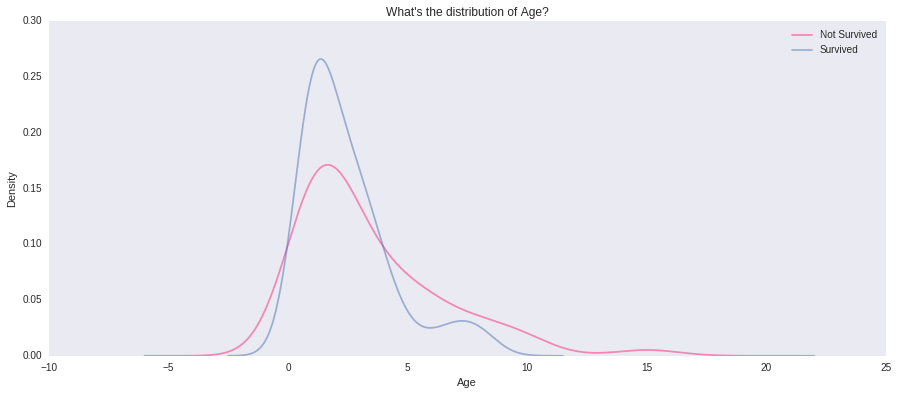

In [440]:
fig = plt.figure(figsize=(15, 6))
alpha = 0.5
apply_data[apply_data.Survived==0].Age.value_counts().plot(kind='density', color='#FA2379', label='Not Survived', alpha=alpha)
apply_data[apply_data.Survived==1].Age.value_counts().plot(kind='density', label='Survived', alpha=alpha)
plt.xlabel('Age')
plt.title("What's the distribution of Age?" )
plt.legend(loc='best')
plt.grid()

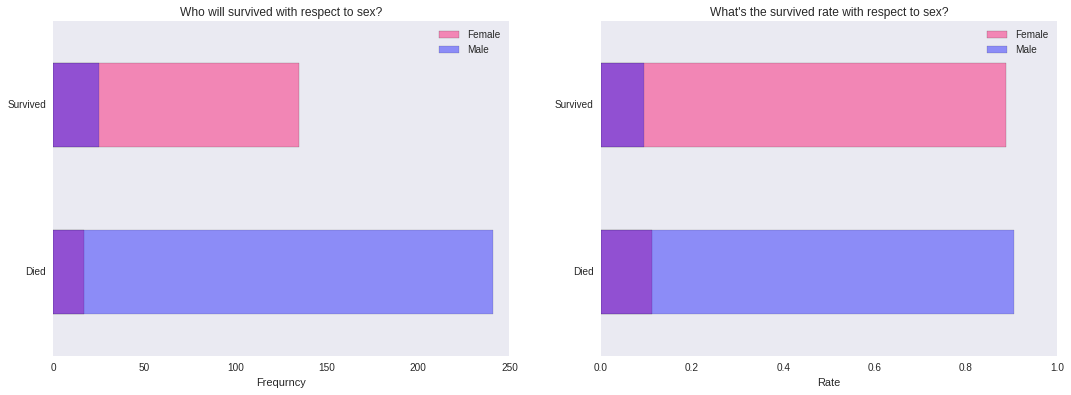

In [441]:
df_male = apply_data[apply_data.Sex=='male'].Survived.value_counts().sort_index()
df_female = apply_data[apply_data.Sex=='female'].Survived.value_counts().sort_index()
fig = plt.figure(figsize=(18, 6))

ax1 = plt.subplot2grid((1,2), (0,0))
df_female.plot(kind='barh', color='#FA2379', label='Female', alpha=alpha)
df_male.plot(kind='barh', label='Male', alpha=alpha-0.1)
ax1.set_xlabel('Frequrncy')
ax1.set_yticklabels(['Died', 'Survived'])
ax1.set_title("Who will survived with respect to sex?" )
plt.legend(loc='best')
plt.grid()

ax2 = plt.subplot2grid((1,2), (0,1))
(df_female/apply_data[apply_data.Sex=='female'].shape[0]).plot(kind='barh', color='#FA2379', label='Female', alpha=alpha)
(df_male/apply_data[apply_data.Sex=='male'].shape[0]).plot(kind='barh', label='Male', alpha=alpha-0.1)
ax2.set_xlabel('Rate')
ax2.set_yticklabels(['Died', 'Survived'])
ax2.set_title("What's the survived rate with respect to sex?" )
plt.legend(loc='best')
plt.grid()

### XGBOOST

In [191]:
from sklearn.externals import joblib
from sklearn.ensemble import BaggingClassifier 

import xgboost as xgb
from scipy import interp

import random

from __future__ import division
from __future__ import print_function

xgc = xgb.XGBClassifier(objective='binary:logistic', max_depth=6, n_estimators=420, learning_rate=0.05,
                        max_delta_step=1, min_child_weight=25, gamma=0.1, scale_pos_weight=0.85, colsample_bytree=0.85,
                        subsample=0.85, colsample_bylevel=1, nthread=12, seed=27)

clfbag_targeting = BaggingClassifier(xgc, n_estimators=10, max_samples=0.9, max_features=0.9)

#train_X = X_train[features_columns_targeting].drop(['svocmasterid'], axis=1).reset_index(drop=True)

#y_train = np.array(dataset_modelA_clean_targeting[target].astype(np.uint8))

clfbag_targeting.fit(train, targets)

BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.85,
       gamma=0.1, learning_rate=0.05, max_delta_step=1, max_depth=6,
       min_child_weight=25, missing=None, n_estimators=420, nthread=12,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.85, seed=27, silent=True, subsample=0.85),
         bootstrap=True, bootstrap_features=False, max_features=0.9,
         max_samples=0.9, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [513]:
output = grid_search.predict(test).astype(int)
df_output = pd.DataFrame()
df_output['PassengerId'] = test['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('data/output0211_xgboost.csv',index=False)